## Load Data

This dataset [Electricity Load Diagrams 20112014 Data Set](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#) is from UCI Machine Learning Repository.

### Data Set Information:

Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

In [2]:
# !curl https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip --output LD2011_2014.txt.zip
# !unzip LD2011_2014.txt.zip
# !ls

In [3]:
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
df = pd.read_csv("LD2011_2014.txt", sep = ';', index_col = 0, dtype=str)

In [4]:
print(df.shape)

(140256, 370)


# Data processing & Pre-Modeling

## Data Cleaning

- Melt the wide data matrix to long data matrix
- Convert index to timestamps, entries to numeric

In [5]:
def preprocessing(dataframe):
    # convert index (timestamp) to a new column
    dataframe = dataframe.reset_index().rename(columns={"index": "timestamp"})

    # unpivot the data
    dataframe = dataframe.melt(id_vars=['timestamp'], var_name='user', value_name='usage_per_15min')
    # fix the timestamp
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    # fix electricity usage
    dataframe['usage_per_15min'] = dataframe['usage_per_15min'].apply(lambda x: str(x).replace(',', '.')).astype(float)

    return dataframe

df = preprocessing(df)

In [6]:
def aggregate_date(dataframe):
    dataframe['date'] = pd.to_datetime((dataframe.timestamp - np.timedelta64(1, 'm')).dt.date)
    dataframe_day = dataframe.groupby(['user', 'date']).sum().reset_index()
    dataframe_day = dataframe_day.rename(columns={'usage_per_15min': 'sum_per_day'})
    dataframe_day['std_per_day'] = dataframe.groupby(['user', 'date']).std().reset_index().usage_per_15min

    return dataframe_day

df_day = aggregate_date(df)
df_day.head()

user       date  sum_per_day  std_per_day
0  MT_001 2011-01-01          0.0          0.0
1  MT_001 2011-01-02          0.0          0.0
2  MT_001 2011-01-03          0.0          0.0
3  MT_001 2011-01-04          0.0          0.0
4  MT_001 2011-01-05          0.0          0.0

user
MT_012    605
MT_015    629
MT_030    493
MT_039    640
MT_041    620
MT_092    395
MT_106    743
MT_107    743
MT_108    743
MT_109    778
MT_110    743
MT_111    743
MT_112    772
MT_113    743
MT_115    743
MT_116    778
MT_117    743
MT_120    743
MT_121    743
MT_122    743
MT_133    801
MT_160    764
MT_165    612
MT_170    423
MT_178    929
MT_179    719
MT_181    794
MT_185    536
MT_186    633
MT_223    829
MT_224    539
MT_289    697
MT_305    707
MT_322    606
MT_337    747
MT_347    622
Name: sum_per_day, dtype: int64


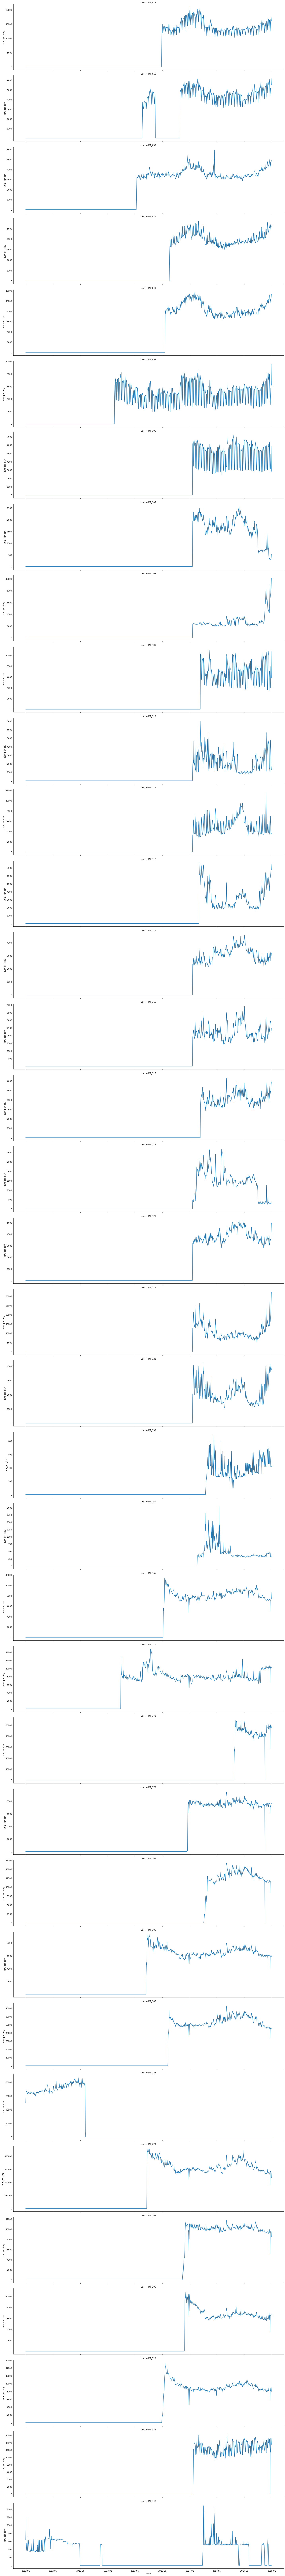

In [7]:
def cleaning(dataframe, threshold=90):
    dataframe = dataframe.copy(deep=True)
    dataframe = dataframe[dataframe.date.dt.year >= 2012]
    # remove the extra day in leap year
    dataframe = dataframe[dataframe.date != pd.to_datetime('20120229')]

    # find users that are active since 2012
    # active_user = [user for user in dataframe.user.unique() if dataframe[(dataframe.user==user) * (dataframe.date==pd.to_datetime('20120101'))].sum_per_day.item() > 0]
    # dataframe = dataframe[dataframe.user.isin(active_user)]

    def without_leading_consecutive_zeros(dataframe, threshold, by="user", col="sum_per_day"):
        # reference: https://datascience.stackexchange.com/questions/20587/find-the-consecutive-zeros-in-a-dataframe-and-do-a-conditional-replacement
        group = dataframe.groupby(by=by)[col].apply(lambda x: (~((x == x.shift()) & (x == 0))).cumsum())
        mask = dataframe[col].groupby(group).transform('count').lt(threshold)
        mask |= (group != 1)
        return mask

    # mask = without_leading_consecutive_zeros(dataframe, threshold)
    # print(f'dropping {(~mask).sum()} rows with leading zeros...')
    # dataframe = dataframe.loc[mask, :]

    # count 0 usage days
    zero_count = dataframe.groupby('user')['sum_per_day'].apply(lambda x: np.sum(x == 0))
    abnormal = zero_count[zero_count > 370]
    print(abnormal)

    sns.relplot(data=dataframe[dataframe.user.isin(abnormal.index)], 
            x="date", y="sum_per_day", row="user",
            kind="line", aspect=4, facet_kws={'sharey': False})

    dataframe = dataframe[~dataframe.user.isin(abnormal.index)]

    return dataframe

df_day_clean = cleaning(df_day)

## Visualize the Dataset

Have a look on the dataset, visualize if there are any trends or seasonality. 

In [8]:

# select 3 random users 
np.random.seed(32)
random_id = np.random.choice(df_day_clean.user.unique().__len__(), 3)
selected_users = df_day_clean.user.unique()[random_id]
print(f'Selected user ids: {selected_users}')

sample_df = df_day_clean[df_day_clean.user.isin(selected_users)]

Selected user ids: ['MT_247' 'MT_049' 'MT_346']


<AxesSubplot:xlabel='date', ylabel='sum_per_day'>

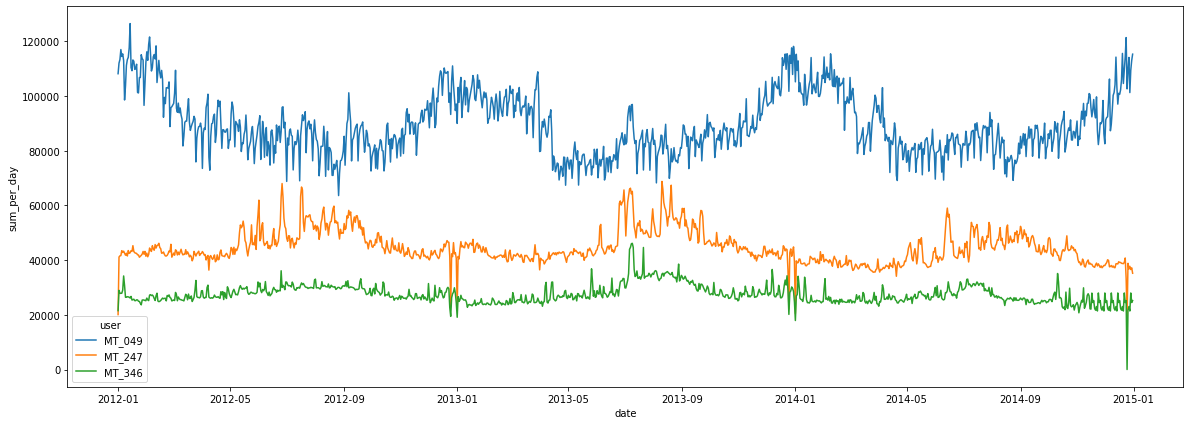

In [9]:
plt.figure(figsize=(20,7))
sns.lineplot(data=sample_df, x="date", y="sum_per_day", hue="user")

## Create features

ex. lag, rolling statistics ... 

In [10]:
def feature_engineering(dataframe_raw, train_test_cutoff = pd.to_datetime('20140101')):

    dataframe = dataframe_raw.copy(deep=True)

    # normalize = (x - mean)/std
    # columns = dataframe.drop(["user", "date"], axis=1).columns
    # columns = ['sum_per_day']

    train_scale_by_user = dataframe.query("date < @train_test_cutoff").groupby("user").sum_per_day.agg(['mean', 'std'])
    train_scale_by_user.rename(columns={'mean': 'overall_mean', 'std': 'overall_std'}, inplace=True)
    # train_scale_by_user.columns = ["_".join(i) for i in train_scale_by_user.columns.to_flat_index()]
    dataframe = dataframe.join(train_scale_by_user, on="user", how="left")

    # for c in columns: 
    dataframe.sum_per_day = (dataframe.sum_per_day - dataframe.overall_mean) / dataframe.overall_std
    dataframe.std_per_day = dataframe.std_per_day / dataframe.overall_std

    # df_baseline = dataframe[['user', 'sum_per_day']][dataframe.date == pd.to_datetime('20120101')]
    # df_baseline = df_baseline.rename(columns={'sum_per_day': 'scale'})
    # dataframe = dataframe.join(df_baseline.set_index('user'), on='user', how='left')
    # dataframe.sum_per_day = dataframe.sum_per_day / dataframe.scale
    # dataframe.std_per_day = dataframe.std_per_day / dataframe.scale

    dataframe.sort_values(by=["user", "date"]).reset_index(drop=True, inplace=True)

    # print(dataframe[dataframe.date == pd.to_datetime('20120101')])
    # print(dataframe.tail())

    dataframe = dataframe.pipe(
        lambda x: x.assign(
            feat_day_std = x["std_per_day"],
            feat_one_day_lag = x.groupby("user")["sum_per_day"].shift(1),
            feat_one_week_lag = x.groupby("user")["sum_per_day"].shift(7),
            feat_one_month_lag = x.groupby("user")["sum_per_day"].shift(30),
            feat_one_year_lag = x.groupby("user")["sum_per_day"].shift(365),

            # feat_one_hour_diff = x.groupby("user")["usage_per_15min"].diff(4),
            # feat_one_day_diff = x.groupby("user")["usage_per_15min"].diff(23*4),
            # these two are not necessary? or the features are not linear independent
            
            feat_one_week_mean = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(8, closed= "left").mean()),
            feat_one_month_mean = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(31, closed= "left").mean()),
            
            feat_one_week_std = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(8, closed= "left").std()),
            feat_one_month_std = x.groupby("user")["sum_per_day"].transform(lambda x: x.rolling(31, closed= "left").std()),

            #target = x["sum_per_day"]
        )
    )

    # drop nas
    dataframe = dataframe.dropna()
    # dataframe = dataframe[dataframe.date.dt.year < 2014]

    # expand date/time variables
    dataframe['feat_year'] = dataframe['date'].dt.year
    # dataframe[[f'feat_{year}' for year in ['2011', '2012', '2013']]] = pd.get_dummies(dataframe.date.dt.year)
    dataframe['feat_month'] = dataframe['date'].dt.month
    dataframe['feat_day'] = dataframe['date'].dt.day
    # dataframe['feat_hour'] = dataframe['timestamp'].dt.hour
    # dataframe['feat_minute'] = dataframe['timestamp'].dt.minute
    dataframe['day_of_week'] = dataframe['date'].dt.dayofweek
    dataframe[[f'feat_{dow}' for dow in ['Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun']]] = pd.get_dummies(dataframe.day_of_week)
    # dataframe['feat_weekend'] = dataframe['feat_day_of_week'].apply(lambda x: 1 if x in [5,6] else 0)

    return dataframe

df_day_feat = feature_engineering(df_day_clean)
df_day_feat.reset_index(drop=True, inplace=True)

df_day_feat['feat_one_day_lag'] = pd.to_numeric(df_day_feat['feat_one_day_lag'])
df_day_feat['feat_one_week_lag'] = pd.to_numeric(df_day_feat['feat_one_week_lag'])
df_day_feat['feat_one_month_lag'] = pd.to_numeric(df_day_feat['feat_one_month_lag'])
df_day_feat['feat_one_year_lag'] = pd.to_numeric(df_day_feat['feat_one_year_lag'])

In [11]:
df_day_feat.head()

user       date  sum_per_day  std_per_day  overall_mean  overall_std  \
0  MT_001 2013-01-01    -0.669876     0.001697    566.267992   519.489646   
1  MT_001 2013-01-02    -0.679648     0.001585    566.267992   519.489646   
2  MT_001 2013-01-03    -0.340092     0.008541    566.267992   519.489646   
3  MT_001 2013-01-04    -0.342534     0.009533    566.267992   519.489646   
4  MT_001 2013-01-05    -0.696748     0.001565    566.267992   519.489646   

   feat_day_std  feat_one_day_lag  feat_one_week_lag  feat_one_month_lag  ...  \
0      0.001697         -0.664991          -0.782248           -0.730948  ...   
1      0.001585         -0.669876          -0.616134           -0.652776  ...   
2      0.008541         -0.679648          -0.745605           -0.547734  ...   
3      0.009533         -0.340092          -0.738276           -0.384063  ...   
4      0.001565         -0.342534          -0.650334           -0.542848  ...   

   feat_month  feat_day  day_of_week  feat_Mon  feat_Tue  feat_Wed  feat_Thr  \
0           1         1            1         0         1         0         0   
1           1         2            2         0         0         1         0   
2           1         3            3         0         0         0         1   
3           1         4            4         0         0         0         0   
4           1         5            5         0         0         0         0   

   feat_Fri  feat_Sat  feat_Sun  
0         0         0         0  
1         0         0         0  
2         0         0         0  
3         1         0         0  
4         0         1         0  

[5 rows x 26 columns]

In [12]:
df_day_feat.columns

Index(['user', 'date', 'sum_per_day', 'std_per_day', 'overall_mean',
       'overall_std', 'feat_day_std', 'feat_one_day_lag', 'feat_one_week_lag',
       'feat_one_month_lag', 'feat_one_year_lag', 'feat_one_week_mean',
       'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std',
       'feat_year', 'feat_month', 'feat_day', 'day_of_week', 'feat_Mon',
       'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun'],
      dtype='object')

### Create train/test splits

In [13]:
# train-test-split
# 80-20 split

training_quantile = 0.8
# train_test_cutoff = np.quantile(df['date'].unique(), training_quantile)
train_test_cutoff = pd.to_datetime('20140401')

train_start = df['timestamp'].min()
train_end = train_test_cutoff
test_start = train_test_cutoff
test_end = df['timestamp'].max()

df_train = df_day_feat.query("date < @train_test_cutoff").reset_index()
df_test = df_day_feat.query("date >= @train_test_cutoff").reset_index()

In [14]:
print("Train-Test Cutoff: {}".format(train_test_cutoff))
print(
    "training set: {},\ntest set:{}".format(df_train.shape, df_test.shape)
)
print("Percentage of data that is reserved for test: ", df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]))

Train-Test Cutoff: 2014-04-01 00:00:00
training set: (151970, 27),
test set:(91850, 27)
Percentage of data that is reserved for test:  0.3767123287671233


In [15]:
df_train.head(10)

index    user       date  sum_per_day  std_per_day  overall_mean  \
0      0  MT_001 2013-01-01    -0.669876     0.001697    566.267992   
1      1  MT_001 2013-01-02    -0.679648     0.001585    566.267992   
2      2  MT_001 2013-01-03    -0.340092     0.008541    566.267992   
3      3  MT_001 2013-01-04    -0.342534     0.009533    566.267992   
4      4  MT_001 2013-01-05    -0.696748     0.001565    566.267992   
5      5  MT_001 2013-01-06    -0.735833     0.001545    566.267992   
6      6  MT_001 2013-01-07    -0.674762     0.001924    566.267992   
7      7  MT_001 2013-01-08    -0.638119     0.004345    566.267992   
8      8  MT_001 2013-01-09    -0.718733     0.002828    566.267992   
9      9  MT_001 2013-01-10    -0.682091     0.004927    566.267992   

   overall_std  feat_day_std  feat_one_day_lag  feat_one_week_lag  ...  \
0   519.489646      0.001697         -0.664991          -0.782248  ...   
1   519.489646      0.001585         -0.669876          -0.616134  ...   
2   519.489646      0.008541         -0.679648          -0.745605  ...   
3   519.489646      0.009533         -0.340092          -0.738276  ...   
4   519.489646      0.001565         -0.342534          -0.650334  ...   
5   519.489646      0.001545         -0.696748          -0.704076  ...   
6   519.489646      0.001924         -0.735833          -0.664991  ...   
7   519.489646      0.004345         -0.674762          -0.669876  ...   
8   519.489646      0.002828         -0.638119          -0.679648  ...   
9   519.489646      0.004927         -0.718733          -0.340092  ...   

   feat_month  feat_day  day_of_week  feat_Mon  feat_Tue  feat_Wed  feat_Thr  \
0           1         1            1         0         1         0         0   
1           1         2            2         0         0         1         0   
2           1         3            3         0         0         0         1   
3           1         4            4         0         0         0         0   
4           1         5            5         0         0         0         0   
5           1         6            6         0         0         0         0   
6           1         7            0         1         0         0         0   
7           1         8            1         0         1         0         0   
8           1         9            2         0         0         1         0   
9           1        10            3         0         0         0         1   

   feat_Fri  feat_Sat  feat_Sun  
0         0         0         0  
1         0         0         0  
2         0         0         0  
3         1         0         0  
4         0         1         0  
5         0         0         1  
6         0         0         0  
7         0         0         0  
8         0         0         0  
9         0         0         0  

[10 rows x 27 columns]

In [16]:
features = list(df_train.columns[df_train.columns.str.startswith('feat_')])
target = 'sum_per_day'
print(f"Features: {features}, total {len(features)}\nTarget: {target}")

Features: ['feat_day_std', 'feat_one_day_lag', 'feat_one_week_lag', 'feat_one_month_lag', 'feat_one_year_lag', 'feat_one_week_mean', 'feat_one_month_mean', 'feat_one_week_std', 'feat_one_month_std', 'feat_year', 'feat_month', 'feat_day', 'feat_Mon', 'feat_Tue', 'feat_Wed', 'feat_Thr', 'feat_Fri', 'feat_Sat', 'feat_Sun'], total 19
Target: sum_per_day


<AxesSubplot:xlabel='date', ylabel='sum_per_day'>

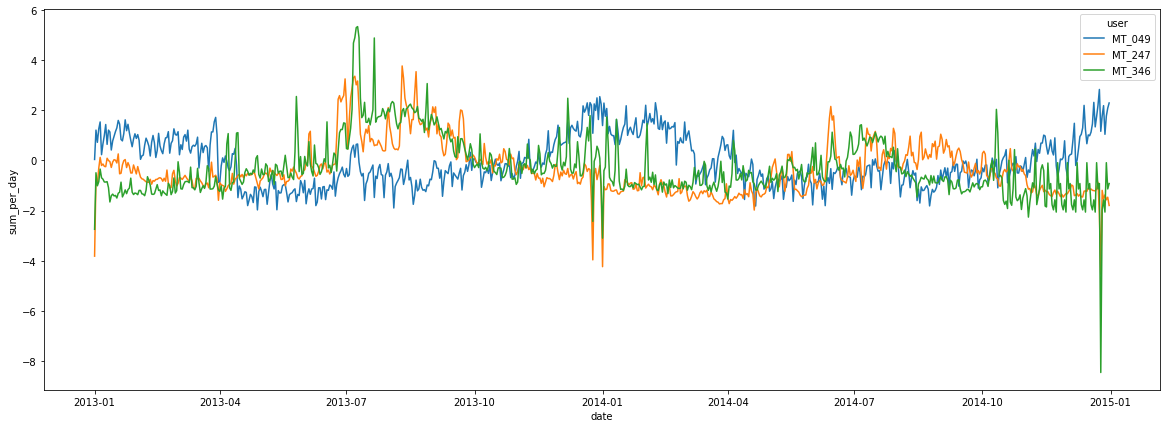

In [17]:
# look at sample after feature engineering 

sample_df_feat = df_day_feat[df_day_feat.user.isin(selected_users)]

plt.figure(figsize=(20,7))
sns.lineplot(data=sample_df_feat, x="date", y="sum_per_day", hue="user")

## Clustering

In [18]:
start = pd.to_datetime('20120131')
wide_df_train = df_train.query("@start <= date")\
    .pivot_table(index="user", columns="date", values="sum_per_day")\
    .dropna(axis=0)
wide_df_train

date    2013-01-01  2013-01-02  2013-01-03  2013-01-04  2013-01-05  \
user                                                                 
MT_001   -0.669876   -0.679648   -0.340092   -0.342534   -0.696748   
MT_002   -0.416152   -0.217579   -0.381110   -0.312972   -0.087144   
MT_003   -0.140776   -0.100571   -0.086622   -0.088263   -0.083340   
MT_004    0.875355    1.399025    0.949189    0.625143    1.215809   
MT_005    0.246832    0.983501    1.169847    0.887603    1.325681   
...            ...         ...         ...         ...         ...   
MT_366   -1.525505   -0.841365   -0.906051   -0.725149   -1.069411   
MT_367   -0.835295   -0.275326   -0.107865    0.091820   -0.184820   
MT_368   -1.767421    0.459778    0.176170    0.530488   -1.236899   
MT_369   -1.472967   -0.448897   -0.438112   -0.336578   -0.980763   
MT_370   -0.195836    0.520444    0.832514    0.810850    0.147496   

date    2013-01-06  2013-01-07  2013-01-08  2013-01-09  2013-01-10  ...  \
user                                                                ...   
MT_001   -0.735833   -0.674762   -0.638119   -0.718733   -0.682091  ...   
MT_002   -0.087144   -0.165016   -0.233154   -0.425886   -5.197472  ...   
MT_003   -0.089904   -0.113699   -0.106315   -0.089084   -0.130930  ...   
MT_004    1.208973    0.582757    0.481578    0.764605    0.432356  ...   
MT_005    1.082668    1.377989    1.187283    1.031450    0.961706  ...   
...            ...         ...         ...         ...         ...  ...   
MT_366   -1.355566   -0.725149   -1.090243   -0.667041   -1.057351  ...   
MT_367   -0.960804   -0.019618    0.244689    0.290463    0.273873  ...   
MT_368   -1.805261    0.366898    1.266263    1.132486    0.922647  ...   
MT_369   -1.706120   -0.574413   -0.352329   -0.307061    0.066012  ...   
MT_370   -0.002506    0.694578    1.184621    0.680867    1.001163  ...   

date    2014-03-22  2014-03-23  2014-03-24  2014-03-25  2014-03-26  \
user                                                                 
MT_001   -0.843319   -0.809119    0.211993    0.185121   -0.669876   
MT_002   -1.249379   -1.169560   -1.282474   -1.372027   -1.409016   
MT_003   -0.284365   -0.289289   -0.299955   -0.295853   -0.294212   
MT_004    2.383469    1.702562    1.084550    1.507040    1.708031   
MT_005    0.377602    0.444076    1.304976    1.309335    1.277732   
...            ...         ...         ...         ...         ...   
MT_366   -0.955388   -1.256892   -0.278923   -1.102303   -0.604547   
MT_367   -0.114727   -1.742606    0.016862    0.328246    0.295066   
MT_368   -1.473493   -1.681421    0.547688    0.851554    0.947873   
MT_369   -1.051575   -1.598696   -0.750236   -0.514742   -0.607903   
MT_370    0.935050    0.802611    0.736173    0.803234    0.691300   

date    2014-03-27  2014-03-28  2014-03-29  2014-03-30  2014-03-31  
user                                                                
MT_001   -0.652776   -0.650334   -0.853090   -0.867747   -0.601477  
MT_002   -1.377867   -1.340878   -1.296102   -1.572546   -1.498568  
MT_003   -0.295032   -0.297494   -0.284365   -0.308981   -0.299955  
MT_004    1.729907    1.914491    2.447731    2.003364    1.684787  
MT_005    1.480425    1.816067    1.128437    0.895231    1.120809  
...            ...         ...         ...         ...         ...  
MT_366   -1.060640   -0.194502   -1.133001   -1.319386   -0.134201  
MT_367   -0.054274    0.377581   -0.129927   -1.110806   -0.009108  
MT_368    0.820594    0.862256   -1.466996   -1.725759    0.530871  
MT_369   -0.602866   -0.496436   -1.145304   -1.842918   -0.835096  
MT_370    0.658455    0.815699    0.769454    0.697719    0.898590  

[334 rows x 455 columns]

In [19]:
valid_users = wide_df_train.index
valid_users

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', name='user', length=334)

In [20]:
# !pip install tslearn

In [21]:
X = wide_df_train.to_numpy()
X.shape

(334, 455)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)

print(X_pca.shape)

(334, 160)


For n_clusters = 2, the average silhouette score is 0.4692
K-Means with 2 clusters done...
For n_clusters = 3, the average silhouette score is 0.3624
K-Means with 3 clusters done...
For n_clusters = 4, the average silhouette score is 0.3182
K-Means with 4 clusters done...
For n_clusters = 5, the average silhouette score is 0.1824
K-Means with 5 clusters done...
For n_clusters = 6, the average silhouette score is 0.1751
K-Means with 6 clusters done...


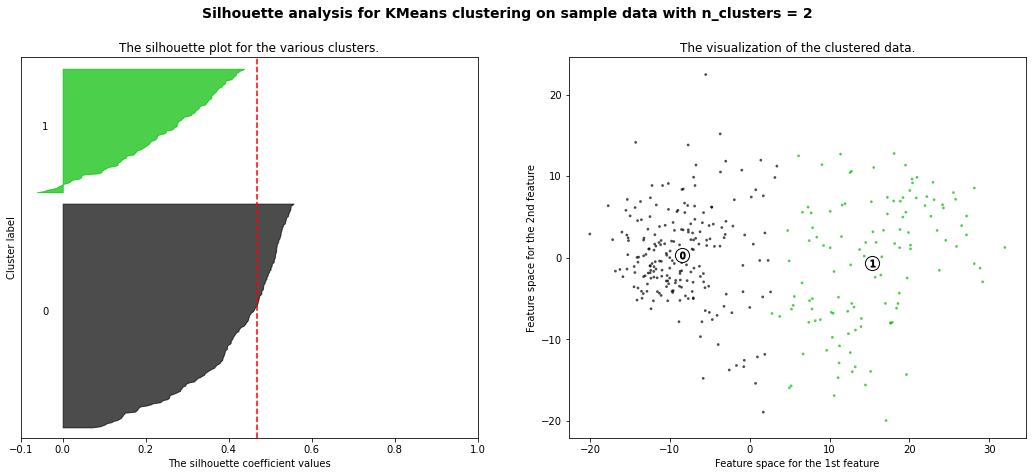

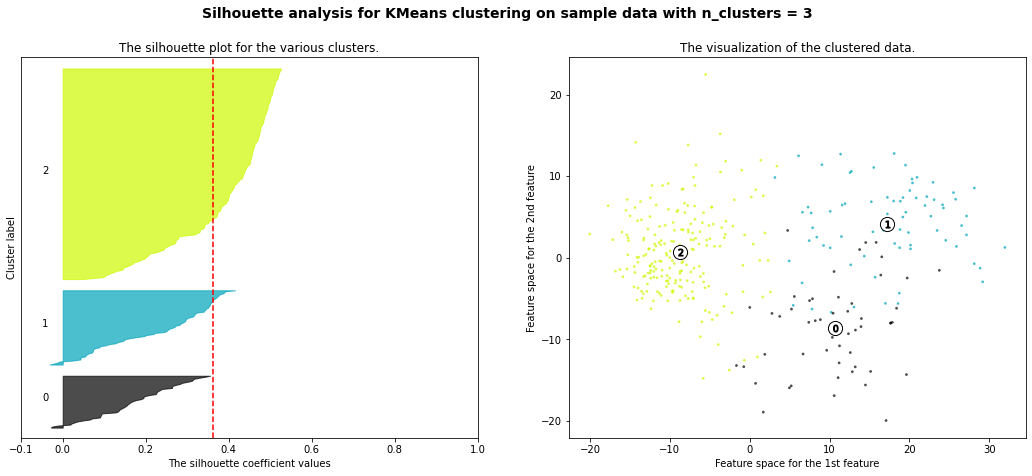

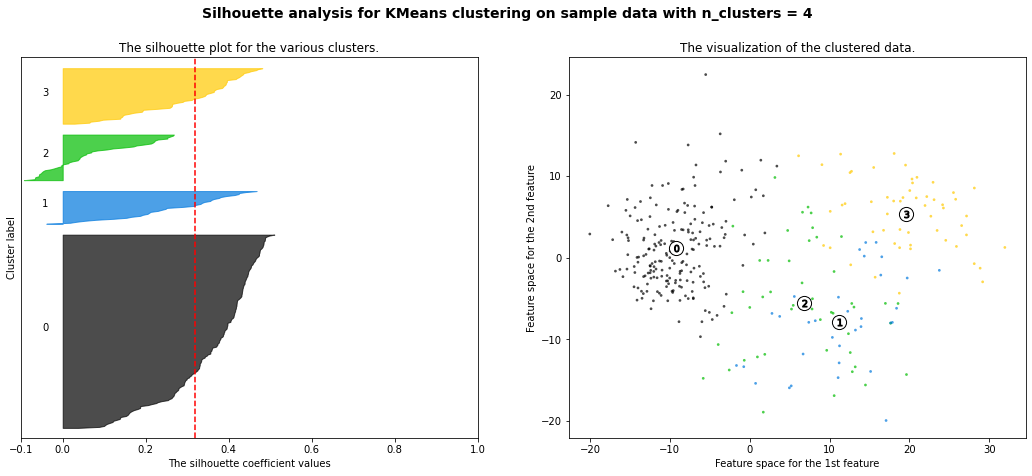

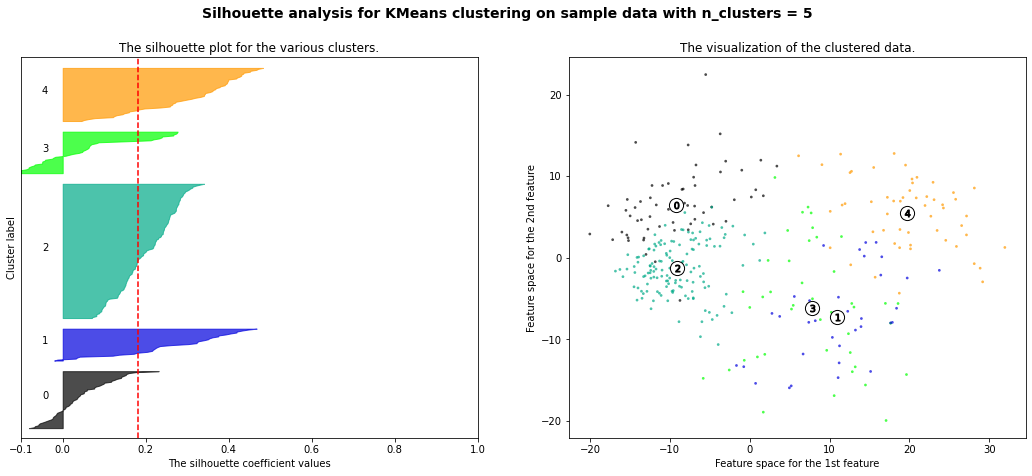

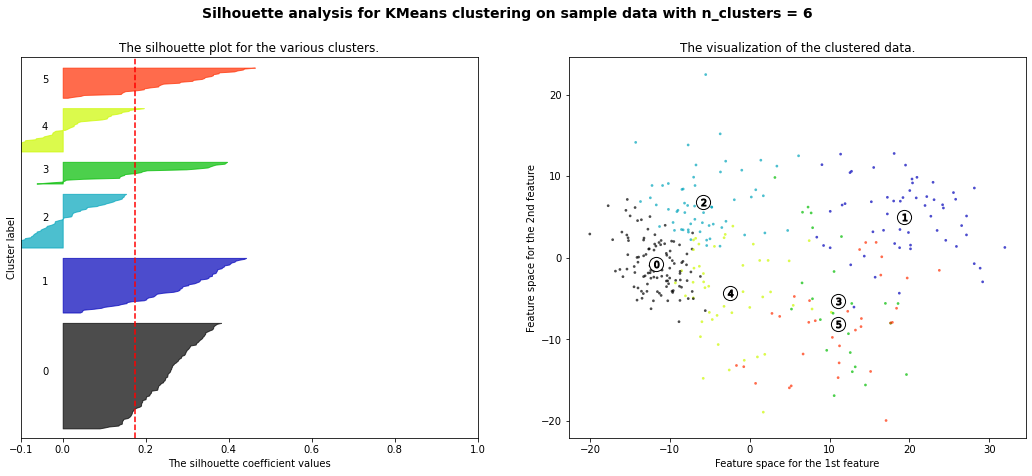

In [23]:
# reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# elbow method and silhouette method

def calculate_cluster_fitness(X, kmax):
    sse = []
    sil = []
    for k in range(2, kmax+1):
        # time series km clustering with dynamic time warping
        tskm = TimeSeriesKMeans(n_clusters=k, n_init=3, metric="dtw", max_iter=50, random_state=0, n_jobs=-1).fit(X)
        sse.append(tskm.inertia_)
        sil.append(silhouette_score(X, tskm.labels_, metric="dtw", random_state=0))

        # regular km clustering with euclidean distance
        km = KMeans(n_clusters=k, random_state=0)
        cluster_labels = km.fit_predict(X)
        sil_avg = silhouette_score(X, cluster_labels, random_state=0)
        sil.append(sil_avg)
        print(f'For n_clusters = {k}, the average silhouette score is {sil_avg:.4f}')

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))
        
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (k + 1) * 10])
        
        y_lower = 10
        for i in range(k):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / k)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=sil_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
        ax2.scatter(
            X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

        # Labeling the clusters
        centers = km.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {k}",
            fontsize=14,
            fontweight="bold",
        )

        print(f'K-Means with {k} clusters done...')
    
    plt.show()

    return sse, sil

# THIS TAKES FOREVER TO RUN!!!
sse, sil = calculate_cluster_fitness(X_pca, 6)

In [26]:
print(sse)
print(sil)

[126.0472089142248, 106.12643794635565, 97.31601493761534, 90.709829398488, 84.38945109759437]
[0.46950445039908145, 0.4692049828361164, 0.370990240386502, 0.36242552392468325, 0.20441030034150717, 0.3181613059186146, 0.20596246846509894, 0.1823661422189298, 0.17962608658492774, 0.1750851227476744]


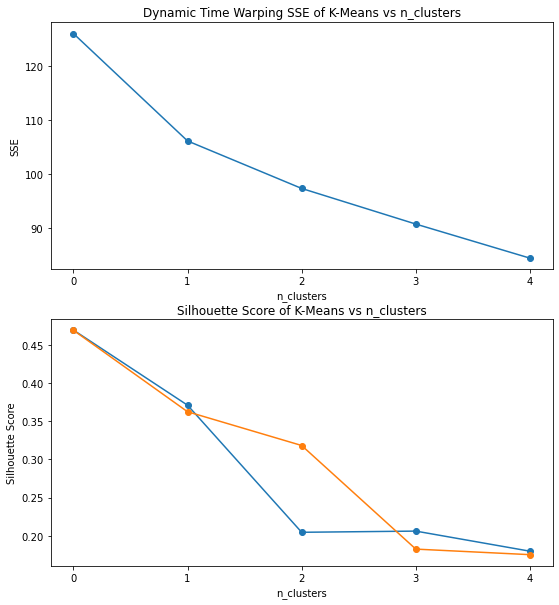

In [30]:
from matplotlib.ticker import MaxNLocator

fig, (ax1, ax2) = plt.subplots(figsize=(9,10), nrows=2, ncols=1)
ax1.plot(sse, '-o', label="SSE of K-Means vs n_clusters")
ax1.set_title("Dynamic Time Warping SSE of K-Means vs n_clusters")
ax1.set_xlabel("n_clusters")
ax1.set_ylabel("SSE")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

ax2.plot(sil[0::2], '-o', label="Silhouette Score (Dynamic Time Warping)")
ax2.plot(sil[1::2], '-o', label="Silhouette Score (Euclidean)")
ax2.set_title("Silhouette Score of K-Means vs n_clusters")
ax2.set_xlabel("n_clusters")
ax2.set_ylabel("Silhouette Score")
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

With Elbow Method, there is a flat line after `n_clusters = 3` which gives us an optimal cluster number. 

With Silhouette Plots, we can see that `n_clusters = 3` passed: 
- all clusters fall above the average Silhouette score,
- clusters have score with less fluctuations,
- the thickness of clusters are close uniform.

We can conclude that `n_clusters = 3` is the optimal parameter for K-Means clustering. 

In [31]:
k = 3
km = TimeSeriesKMeans(n_clusters=k, n_init=3, metric="dtw", max_iter=50, random_state=0, n_jobs=-1)
km.fit(X)

TimeSeriesKMeans(metric='dtw', n_init=3, n_jobs=-1, random_state=0)

In [35]:
# results from local
labels = np.array([
    2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 
    2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 
    1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 
    2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 
    1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2
])
labels

array([2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 1,
       1, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0,

c:\Users\jinyu\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 334 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


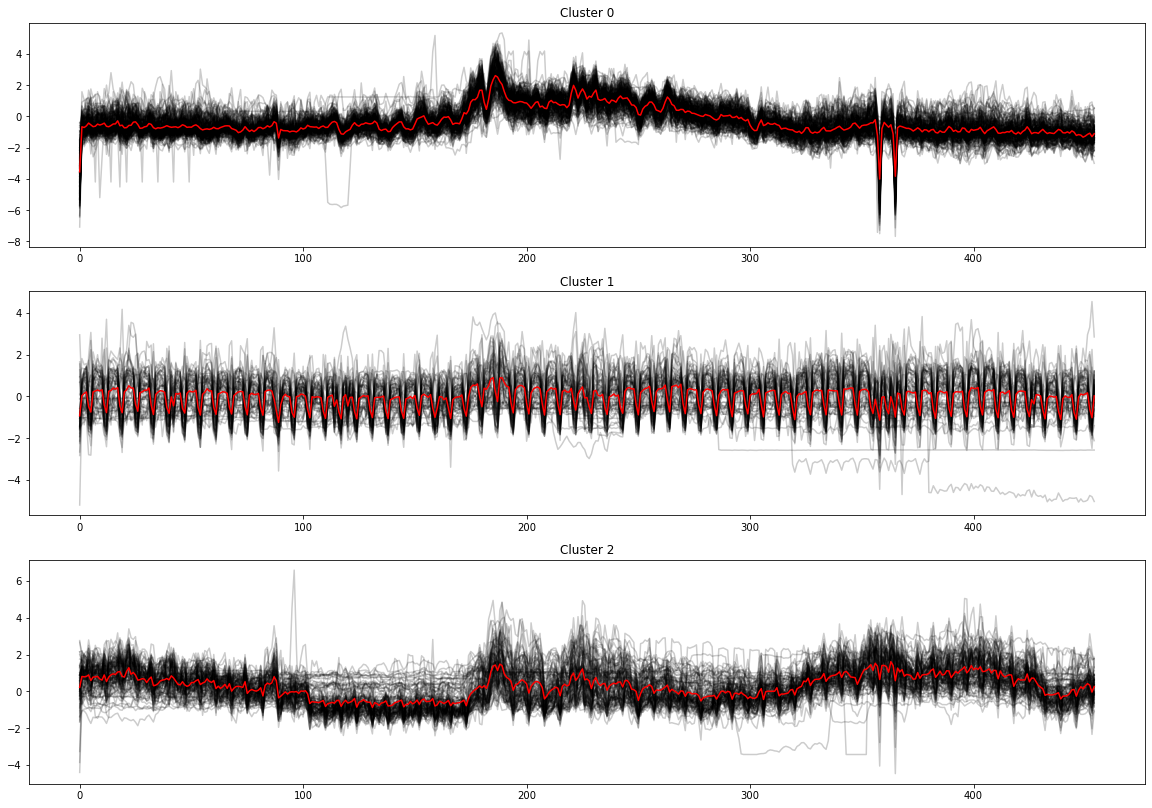

In [32]:
# labels = km.predict(X)
fig, axes = plt.subplots(figsize=(20,14), nrows=k, ncols=1)
for yi, ax in zip(range(k), axes.ravel()):
    for xx in X[labels == yi]:
        ax.plot(xx.ravel(), "k-", alpha=.2)
    ax.plot(np.mean(X[labels == yi], axis=0), "r-")
    # ax.plot(km.cluster_centers_[yi].ravel(), "r-")
    ax.set_title(f"Cluster {yi}")

plt.show()

In [36]:
from IPython.core.display import HTML

user_clusters = pd.DataFrame(zip(valid_users, labels), columns=["user", "cluster"])

display(HTML(user_clusters.to_html()))

display_cluster = user_clusters.copy(deep=True)
display_cluster["idx"] = display_cluster.sort_values(["user", "cluster"]).groupby("cluster").cumcount()
display_cluster = pd.pivot_table(data=display_cluster, index="idx", columns="cluster", values="user", aggfunc=lambda x: ' '.join(x), fill_value="").add_prefix("cluster_")
display(HTML(display_cluster.to_html()))

Merge the cluster info with our main dataframes.

In [37]:
df_train_with_cluster = df_train.merge(user_clusters, on='user')
df_test_with_cluster = df_test.merge(user_clusters, on='user')
df_train_with_cluster.head(10)

index    user       date  sum_per_day  std_per_day  overall_mean  \
0      0  MT_001 2013-01-01    -0.669876     0.001697    566.267992   
1      1  MT_001 2013-01-02    -0.679648     0.001585    566.267992   
2      2  MT_001 2013-01-03    -0.340092     0.008541    566.267992   
3      3  MT_001 2013-01-04    -0.342534     0.009533    566.267992   
4      4  MT_001 2013-01-05    -0.696748     0.001565    566.267992   
5      5  MT_001 2013-01-06    -0.735833     0.001545    566.267992   
6      6  MT_001 2013-01-07    -0.674762     0.001924    566.267992   
7      7  MT_001 2013-01-08    -0.638119     0.004345    566.267992   
8      8  MT_001 2013-01-09    -0.718733     0.002828    566.267992   
9      9  MT_001 2013-01-10    -0.682091     0.004927    566.267992   

   overall_std  feat_day_std  feat_one_day_lag  feat_one_week_lag  ...  \
0   519.489646      0.001697         -0.664991          -0.782248  ...   
1   519.489646      0.001585         -0.669876          -0.616134  ...   
2   519.489646      0.008541         -0.679648          -0.745605  ...   
3   519.489646      0.009533         -0.340092          -0.738276  ...   
4   519.489646      0.001565         -0.342534          -0.650334  ...   
5   519.489646      0.001545         -0.696748          -0.704076  ...   
6   519.489646      0.001924         -0.735833          -0.664991  ...   
7   519.489646      0.004345         -0.674762          -0.669876  ...   
8   519.489646      0.002828         -0.638119          -0.679648  ...   
9   519.489646      0.004927         -0.718733          -0.340092  ...   

   feat_day  day_of_week  feat_Mon  feat_Tue  feat_Wed  feat_Thr  feat_Fri  \
0         1            1         0         1         0         0         0   
1         2            2         0         0         1         0         0   
2         3            3         0         0         0         1         0   
3         4            4         0         0         0         0         1   
4         5            5         0         0         0         0         0   
5         6            6         0         0         0         0         0   
6         7            0         1         0         0         0         0   
7         8            1         0         1         0         0         0   
8         9            2         0         0         1         0         0   
9        10            3         0         0         0         1         0   

   feat_Sat  feat_Sun  cluster  
0         0         0        2  
1         0         0        2  
2         0         0        2  
3         0         0        2  
4         1         0        2  
5         0         1        2  
6         0         0        2  
7         0         0        2  
8         0         0        2  
9         0         0        2  

[10 rows x 28 columns]

## Baseline Model: Linear Regression

### With one user

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

# Partial Fit

user = 'MT_300'
df_train_sample = df_train[df_train.user == user]  # .sample(frac=0.3, random_state=42)
df_test_sample = df_test[df_test.user == user]


lr = LinearRegression()
lr.fit(df_train_sample[features], df_train_sample[target])
y_pred = lr.predict(df_test_sample[features])

# Training MSE
print("Training MSE: {}".format(np.mean((lr.predict(df_train_sample[features]) - df_train_sample[target].to_numpy())**2)))
# Test MSE
print("Testing MSE:  {}".format(np.mean((y_pred - df_test_sample[target].to_numpy())**2)))

print(f"Training MAPE: {mean_absolute_percentage_error(df_train_sample[target].to_numpy(), lr.predict(df_train_sample[features])):.4f}")
print(f"Testing MAPE:  {mean_absolute_percentage_error(df_test_sample[target].to_numpy(), y_pred):.4f}")

Training MSE: 0.17051321209127437
Testing MSE:  0.2747724482619655
Training MAPE: 1.1463
Testing MAPE:  2.1069


(275, 27)
(275, 27)


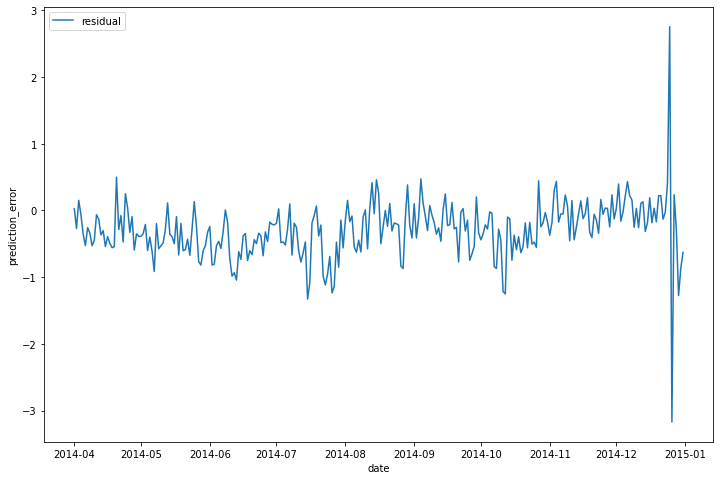

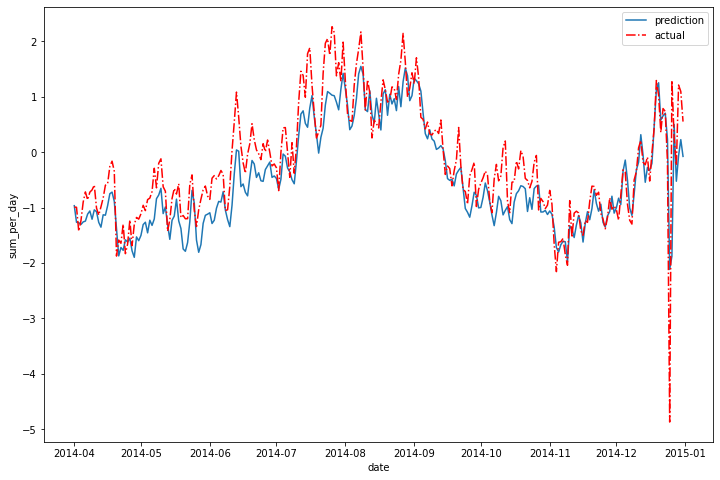

In [46]:
# Plot prediction for user x

def plot_prediction(dataframe, model, user = 'MT_001', time_interval = (20110102, 20150101)):
    time_start = time_interval[0]
    time_end = time_interval[1]
    # subset time range
    temp_df = dataframe.query("@time_start <= date <= @time_end").copy()
    temp_df = temp_df.query("user == @user")
    print(temp_df.shape)
    # inference
    y_hat = model.predict(temp_df[features])
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(temp_df['date'], y_hat, label='prediction')
    ax.plot(temp_df['date'], temp_df[target], label='actual', linestyle='-.', color='red')

    ax.set_xlabel("date")
    ax.set_ylabel("sum_per_day")
    ax.legend()

def plot_error(dataframe, model, user = 'MT_001', time_interval = (20110102, 20150101)):
    time_start = time_interval[0]
    time_end = time_interval[1]
    # subset time range
    temp_df = dataframe.query("@time_start <= date <= @time_end").copy()
    temp_df = temp_df.query("user == @user")
    print(temp_df.shape)
    # inference
    y_hat = model.predict(temp_df[features])
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(temp_df['date'], y_hat - temp_df[target], label='residual')

    ax.set_xlabel("date")
    ax.set_ylabel("prediction_error")
    ax.legend()

plot_error(df_test, lr, user = user)
plot_prediction(df_test, lr, user = user)
# plot_error(df_test, lr, user = user, time_interval = (pd.to_datetime("20130801"), pd.to_datetime("20130831")))
# plot_prediction(df_test, lr, user = user, time_interval = (pd.to_datetime("20130801"), pd.to_datetime("20130831")))

In [47]:
def mean_residual_per_day(dataframe, model, user = 'All', time_interval = (20110102, 20150101), ax = None, label = None):
    time_start = time_interval[0]
    time_end = time_interval[1]

    # subset time range
    temp_df = dataframe.query("@time_start <= date <= @time_end").copy()
    if user != 'All' and user[:2] == 'MT':
        temp_df = temp_df.query("user == @user")

    # temp_df['date'] = temp_df['timestamp'].dt.date

    # inference
    temp_df['y_hat'] = model.predict(temp_df[features])
    temp_df['residual'] = np.abs(temp_df['y_hat'] - temp_df[target])
    
    # plot
    if ax is None:
        raise ValueError("ax is None")
    
    ax.plot(temp_df.groupby('date')['residual'].mean().index, temp_df.groupby('date')['residual'].mean().values, label=label)


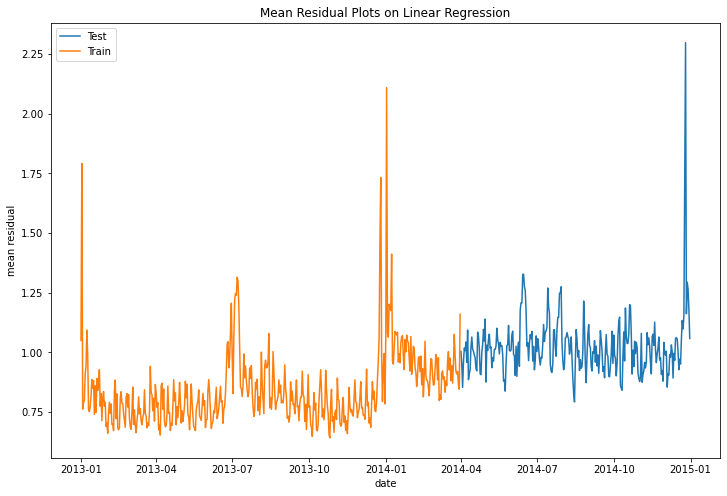

In [49]:
fig, ax = plt.subplots(figsize=(12, 8))
mean_residual_per_day(df_test, lr, user = 'All', time_interval = (test_start, test_end), ax = ax, label = 'Test')
mean_residual_per_day(df_train, lr, user = 'All', time_interval = (train_start, train_end), ax = ax, label = 'Train')
ax.set_xlabel("date")
ax.set_ylabel("mean residual")
ax.set_title("Mean Residual Plots on Linear Regression")
ax.legend()

### With multiple user by cluster

In [50]:
def train_test_split_by_cluster(df_train, df_test, cluster_index, features, target, shuffle=True):
    df_train_subset = df_train.query("cluster == @cluster_index")
    df_test_subset = df_test.query("cluster == @cluster_index")

    if shuffle:
        df_train_subset = df_train_subset.sample(frac=1, random_state=0).reset_index(drop=True)
        df_test_subset = df_test_subset.sample(frac=1, random_state=0).reset_index(drop=True)

    X_train = df_train_subset[features]
    y_train = df_train_subset[target]
    X_test = df_test_subset[features]
    y_test = df_test_subset[target]
    
    return X_train, X_test, y_train, y_test

Cross validation R2 score with 5 folds for cluster = 0: [0.80111819 0.79531133 0.80153991 0.79508805 0.80282576]
R2 score on testing sets for cluster = 0: 0.7769
Training MAPE: 1.6378
Testing MAPE:  2.7999
Cross validation R2 score with 5 folds for cluster = 1: [0.75984332 0.75335212 0.76996654 0.76498149 0.74616965]
R2 score on testing sets for cluster = 1: 0.8338
Training MAPE: 1.5365
Testing MAPE:  1.2923
Cross validation R2 score with 5 folds for cluster = 2: [0.83444553 0.82007466 0.82718694 0.82728194 0.83737001]
R2 score on testing sets for cluster = 2: 0.8296
Training MAPE: 2.2906
Testing MAPE:  2.2560


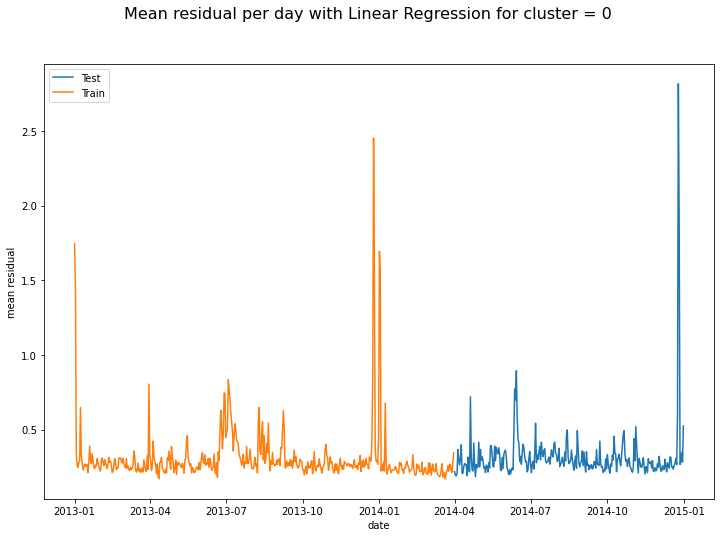

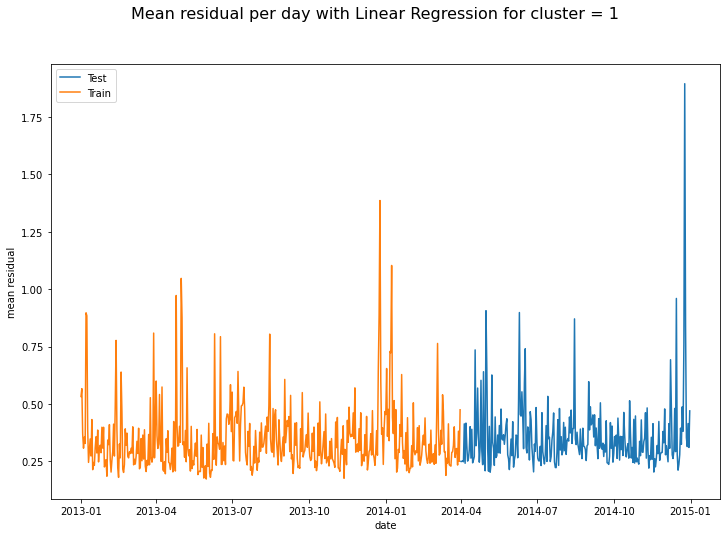

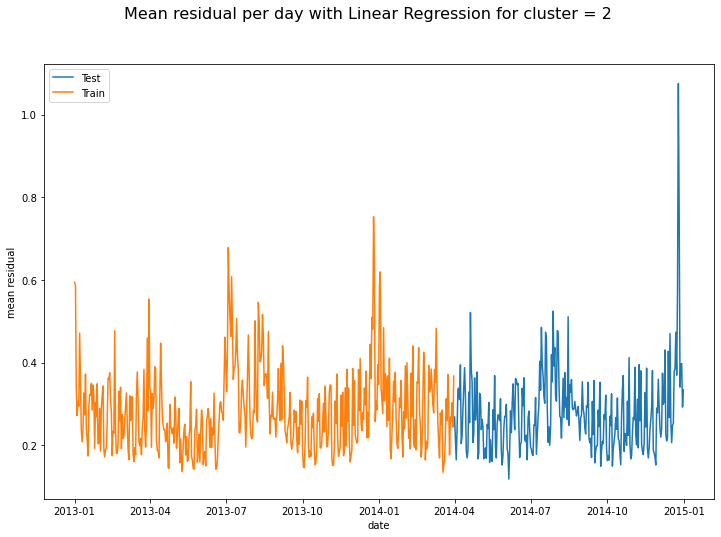

In [52]:
# Create baseline model for each cluster
lr_models = [] 

for i in range(k):
    X_train, X_test, y_train, y_test = train_test_split_by_cluster(df_train_with_cluster, df_test_with_cluster, cluster_index=i, features=features, target=target)
    model = LinearRegression()
    print(f"Cross validation R2 score with 5 folds for cluster = {i}: {cross_val_score(model, X_train, y_train)}")
    model.fit(X_train, y_train)
    print(f"R2 score on testing sets for cluster = {i}: {model.score(X_test, y_test):.4f}")

    print(f"Training MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.4f}")
    print(f"Testing MAPE:  {mean_absolute_percentage_error(y_test, model.predict(X_test)):.4f}")

    # plot 
    fig, ax = plt.subplots(figsize=(12, 8))
    mean_residual_per_day(df_test_with_cluster.query("cluster == @i"), model, user = 'All', time_interval = (test_start, test_end), ax = ax, label = 'Test')
    mean_residual_per_day(df_train_with_cluster.query("cluster == @i"), model, user = 'All', time_interval = (train_start, train_end), ax = ax, label = 'Train')
    ax.set_xlabel("date")
    ax.set_ylabel("mean residual")
    plt.suptitle(f"Mean residual per day with Linear Regression for cluster = {i}", fontsize=16)
    ax.legend()

    lr_models.append(model)

(275, 27)
(275, 27)
(275, 27)


<Figure size 864x576 with 0 Axes>

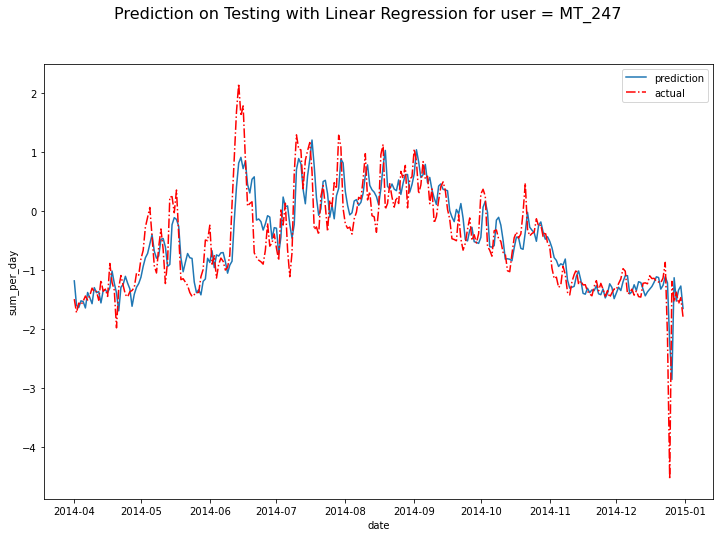

<Figure size 864x576 with 0 Axes>

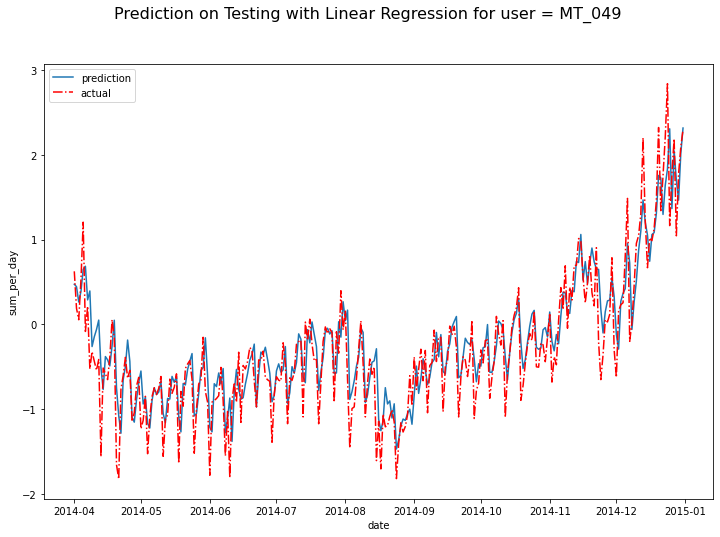

<Figure size 864x576 with 0 Axes>

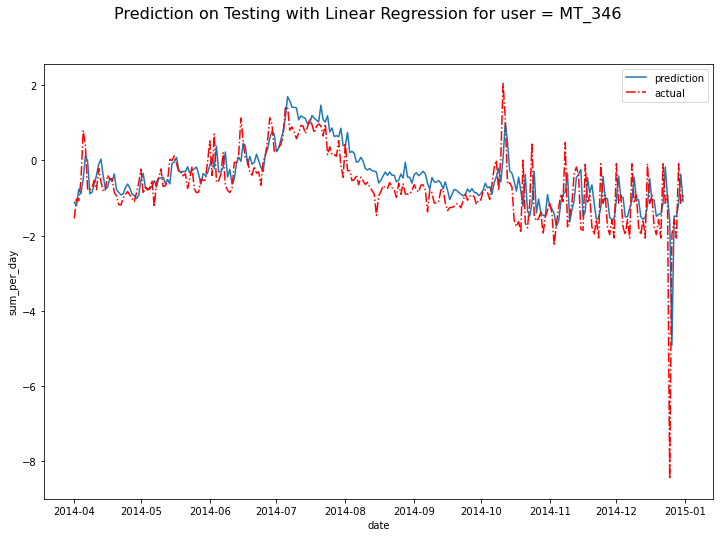

In [53]:
# plot prediction on selected user

for user in selected_users:
    cluster_index = user_clusters.query("user == @user").cluster.values[0]
    fig = plt.figure(figsize=(12, 8))
    plot_prediction(df_test, lr_models[cluster_index], user = user, time_interval = (test_start, test_end))
    plt.suptitle(f"Prediction on Testing with Linear Regression for user = {user}", fontsize=16)

## Baseline Model: Random Forest

Cross validation R2 score with 5 folds for cluster = 0: [0.86799195 0.87637428 0.87892166 0.86993888 0.87904993]
R2 score on testing sets for cluster = 0: 0.8281
Training MAPE: 0.8892
Testing MAPE:  2.6164
Cross validation R2 score with 5 folds for cluster = 1: [0.84873657 0.83736071 0.84165574 0.85508606 0.83723113]
R2 score on testing sets for cluster = 1: 0.8632
Training MAPE: 0.5604
Testing MAPE:  1.1307
Cross validation R2 score with 5 folds for cluster = 2: [0.86317198 0.84863116 0.85690395 0.85625496 0.86738525]
R2 score on testing sets for cluster = 2: 0.8451
Training MAPE: 1.1689
Testing MAPE:  2.1695


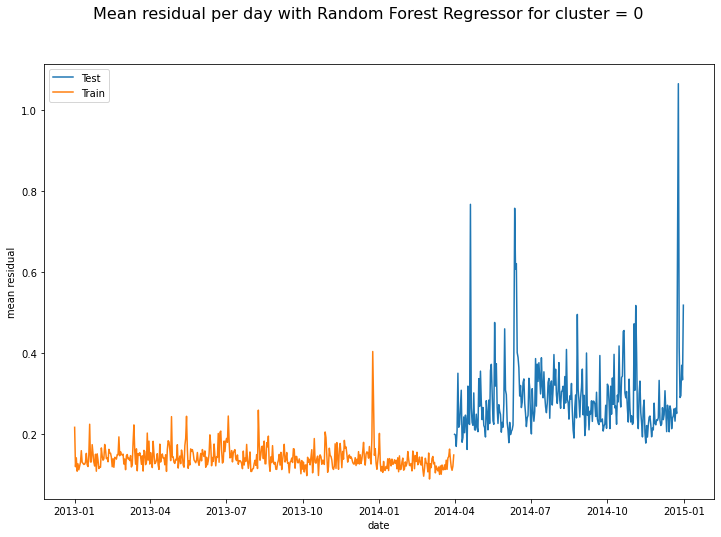

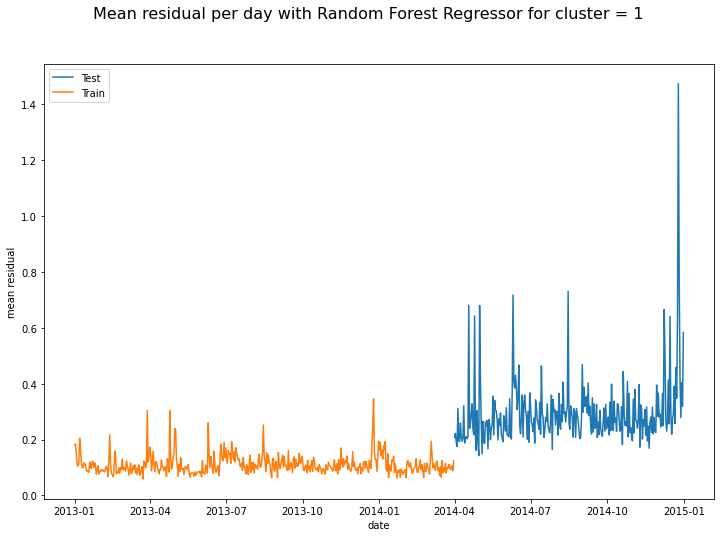

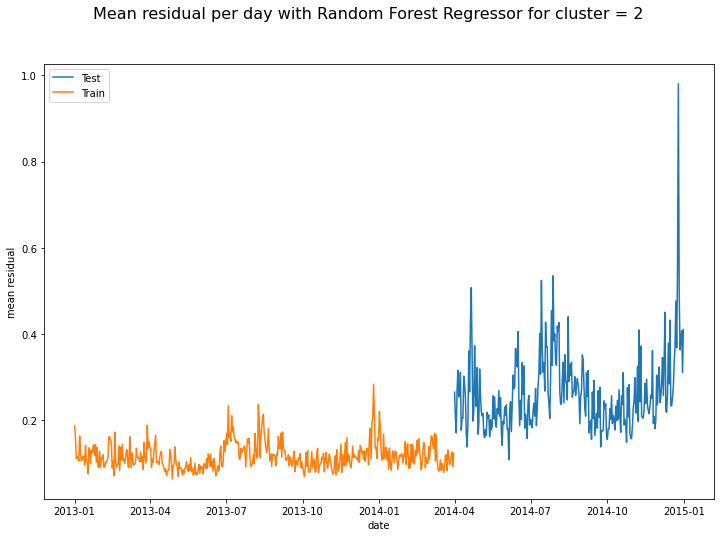

In [54]:
from sklearn.ensemble import RandomForestRegressor

# Create baseline model for each cluster
dt_models = [] 

for i in range(k):
    X_train, X_test, y_train, y_test = train_test_split_by_cluster(df_train_with_cluster, df_test_with_cluster, cluster_index=i, features=features, target=target)
    model = RandomForestRegressor(n_estimators=25, criterion='squared_error', max_depth=20, random_state=0)
    print(f"Cross validation R2 score with 5 folds for cluster = {i}: {cross_val_score(model, X_train, y_train)}")
    model.fit(X_train, y_train)
    print(f"R2 score on testing sets for cluster = {i}: {model.score(X_test, y_test):.4f}")

    print(f"Training MAPE: {mean_absolute_percentage_error(y_train, model.predict(X_train)):.4f}")
    print(f"Testing MAPE:  {mean_absolute_percentage_error(y_test, model.predict(X_test)):.4f}")

    # plot 
    fig, ax = plt.subplots(figsize=(12, 8))
    mean_residual_per_day(df_test_with_cluster.query("cluster == @i"), model, user = 'All', time_interval = (test_start, test_end), ax = ax, label = 'Test')
    mean_residual_per_day(df_train_with_cluster.query("cluster == @i"), model, user = 'All', time_interval = (train_start, train_end), ax = ax, label = 'Train')
    ax.set_xlabel("date")
    ax.set_ylabel("mean residual")
    plt.suptitle(f"Mean residual per day with Random Forest Regressor for cluster = {i}", fontsize=16)
    ax.legend()

    dt_models.append(model)

(275, 27)
(275, 27)
(275, 27)


<Figure size 864x576 with 0 Axes>

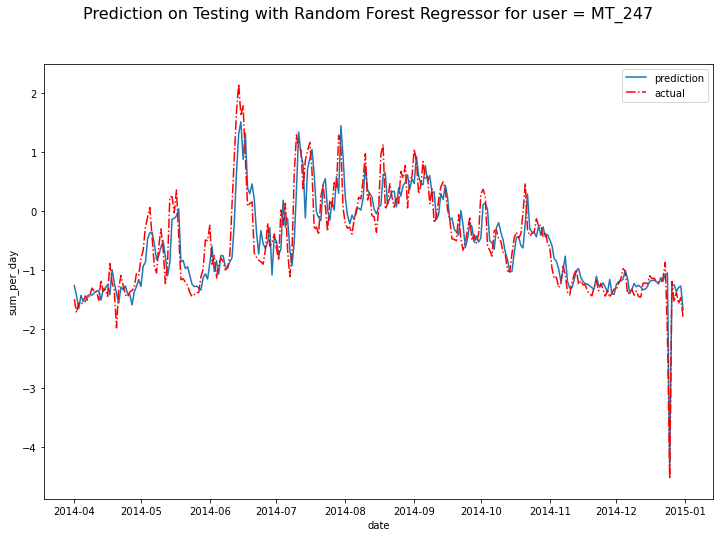

<Figure size 864x576 with 0 Axes>

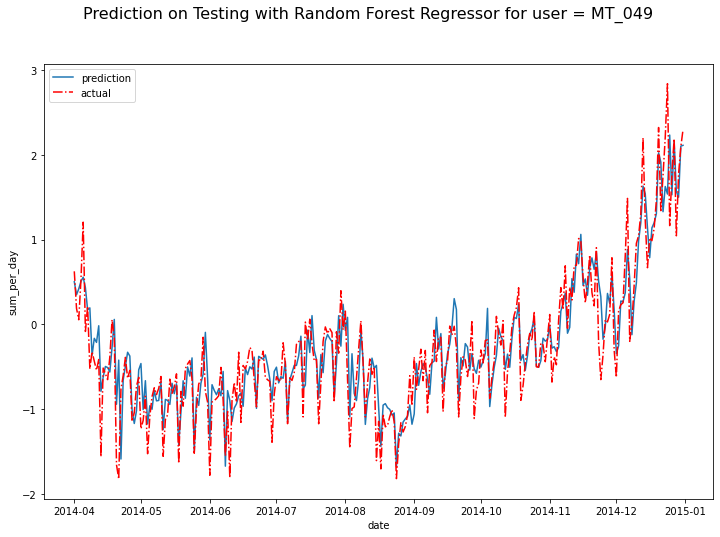

<Figure size 864x576 with 0 Axes>

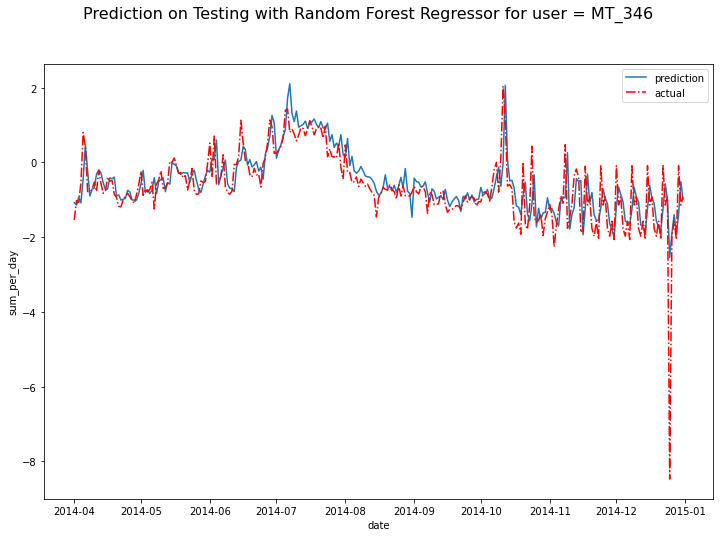

In [55]:
# plot prediction on selected user

for user in selected_users:
    cluster_index = user_clusters.query("user == @user").cluster.values[0]
    fig = plt.figure(figsize=(12, 8))
    plot_prediction(df_test, dt_models[cluster_index], user = user, time_interval = (test_start, test_end))
    plt.suptitle(f"Prediction on Testing with Random Forest Regressor for user = {user}", fontsize=16)